<a href="https://colab.research.google.com/github/gavinzli/MFIT-5009/blob/main/5009_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Packages

In [179]:
!pip install -q yfinance PyPortfolioOpt

In [180]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
from pypfopt import DiscreteAllocation
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import HRPOpt
from pypfopt import plotting
from pypfopt import EfficientFrontier
from pypfopt import EfficientSemivariance
from pypfopt import EfficientCVaR
from pypfopt import EfficientCDaR
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Parameter Setting

In [181]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA",
           "JD", "BA", '^TYX','^TNX','^FVX', '^IRX']
tickers = sorted(tickers)

In [182]:
sector_mapper = {}
country_mapper = {}
industry_mapper = {}
type_mapper = {}
for t in tickers:
    stock = yf.Ticker(t)
    try:
        type_mapper[t] = stock.info['quoteType']
    except Exception as e:
        type_mapper[t] = None
    try:
        country_mapper[t] = stock.info['country']
    except Exception as e:
        country_mapper[t] = None
    try:
        sector_mapper[t] = stock.info['sector']
    except Exception as e:
        sector_mapper[t] = None
    try:
        industry_mapper[t] = stock.info['industry']
    except Exception as e:
        industry_mapper[t] = None

In [183]:
sector_mapper

{'ACN': 'Technology',
 'AMZN': 'Consumer Cyclical',
 'BA': 'Industrials',
 'COST': 'Consumer Defensive',
 'DIS': 'Communication Services',
 'F': 'Consumer Cyclical',
 'GILD': 'Healthcare',
 'JD': 'Consumer Cyclical',
 'JPM': 'Financial Services',
 'KO': 'Consumer Defensive',
 'MA': 'Financial Services',
 'MSFT': 'Technology',
 'PFE': 'Healthcare',
 'TSLA': 'Consumer Cyclical',
 'UNH': 'Healthcare',
 'XOM': 'Energy',
 '^FVX': None,
 '^IRX': None,
 '^TNX': None,
 '^TYX': None}

In [184]:
sector_lower = {
    "Consumer Cyclical": 0.1, # at least 10% to staples
    "Technology": 0.05, # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}
sector_upper = {
    "Technology": 0.2,
    "Energy":0.1,
    "Healthcare": 0.1,
    "Consumer Cyclical":0.15
}

In [185]:
 country_mapper

{'ACN': 'Ireland',
 'AMZN': 'United States',
 'BA': 'United States',
 'COST': 'United States',
 'DIS': 'United States',
 'F': 'United States',
 'GILD': 'United States',
 'JD': 'China',
 'JPM': 'United States',
 'KO': 'United States',
 'MA': 'United States',
 'MSFT': 'United States',
 'PFE': 'United States',
 'TSLA': 'United States',
 'UNH': 'United States',
 'XOM': 'United States',
 '^FVX': None,
 '^IRX': None,
 '^TNX': None,
 '^TYX': None}

In [186]:
country_lower = {
    "United States": 0.1
}

country_upper = {
    "China": 0.2,
    "Ireland":0.1
}

In [187]:
weight_contraint = {
    "AMZN": {
        "sign": ">=",
        "value": 0.01
    },
    "TSLA": {
        "sign": ">=",
        "value": 0.01
    }
}

In [188]:
industry_mapper

{'ACN': 'Information Technology Services',
 'AMZN': 'Internet Retail',
 'BA': 'Aerospace & Defense',
 'COST': 'Discount Stores',
 'DIS': 'Entertainment',
 'F': 'Auto Manufacturers',
 'GILD': 'Drug Manufacturers—General',
 'JD': 'Internet Retail',
 'JPM': 'Banks—Diversified',
 'KO': 'Beverages—Non-Alcoholic',
 'MA': 'Credit Services',
 'MSFT': 'Software—Infrastructure',
 'PFE': 'Drug Manufacturers—General',
 'TSLA': 'Auto Manufacturers',
 'UNH': 'Healthcare Plans',
 'XOM': 'Oil & Gas Integrated',
 '^FVX': None,
 '^IRX': None,
 '^TNX': None,
 '^TYX': None}

In [189]:
type_mapper

{'ACN': 'EQUITY',
 'AMZN': 'EQUITY',
 'BA': 'EQUITY',
 'COST': 'EQUITY',
 'DIS': 'EQUITY',
 'F': 'EQUITY',
 'GILD': 'EQUITY',
 'JD': 'EQUITY',
 'JPM': 'EQUITY',
 'KO': 'EQUITY',
 'MA': 'EQUITY',
 'MSFT': 'EQUITY',
 'PFE': 'EQUITY',
 'TSLA': 'EQUITY',
 'UNH': 'EQUITY',
 'XOM': 'EQUITY',
 '^FVX': 'INDEX',
 '^IRX': 'INDEX',
 '^TNX': 'INDEX',
 '^TYX': 'INDEX'}

In [190]:
type_lower = {
    "INDEX": 0.1
}

type_upper = {
    "INDEX": 0.2
}

In [191]:
risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

In [192]:
risk_methods = [
    "sample_cov",
    "exp_cov",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

In [193]:
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
]



*   min_volatility() optimizes for minimum volatility
*   max_sharpe() optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)
*   max_quadratic_utility() maximises the quadratic utility, given some risk aversion.
*   efficient_risk() maximises return for a given target risk
*   efficient_return() minimises risk for a given target return



In [194]:
optimizer = {
    "min_volatility": None,
    "max_sharpe": None,
    "max_quadratic_utility": 0.5,
    "efficient_risk": 0.5,
    "efficient_return": 0.1,
}

# Download Data

In [195]:
def download(tickers):
  ohlc = yf.download(tickers, period="max")
  prices = ohlc["Adj Close"].dropna(how="all")
  return prices
prices = download(tickers).dropna()
prices.tail(10)

[*********************100%***********************]  20 of 20 completed


,ACN,AMZN,BA,COST,DIS,F,GILD,JD,JPM,KO,MA,MSFT,PFE,TSLA,UNH,XOM,^FVX,^IRX,^TNX,^TYX
Date,,,,,,,,,,,,,,,,,,,,
2023-04-20,275.549988,103.809998,207.229996,505.579987,98.070000,11.723577,84.690002,36.189999,140.809998,63.959999,375.000000,286.109985,39.849998,162.990005,487.459991,115.639999,3.640,4.945,3.545,3.753
2023-04-21,276.329987,106.959999,205.149994,506.350006,99.570000,11.664318,86.570000,35.630001,140.539993,64.050003,375.239990,285.760010,40.209999,165.080002,483.820007,116.010002,3.661,4.950,3.570,3.778
2023-04-24,277.250000,106.209999,205.770004,511.420013,99.680000,12.009999,86.699997,34.680000,140.729996,63.950001,374.730011,281.769989,39.910000,162.550003,488.940002,118.199997,3.605,4.873,3.515,3.728
2023-04-25,270.700012,102.570000,202.190002,503.170013,98.010002,11.770000,85.589996,33.700001,137.669998,63.849998,368.529999,275.420013,39.330002,160.669998,491.920013,116.519997,3.442,4.953,3.396,3.651
2023-04-26,271.209991,104.980003,203.029999,494.660004,96.610001,11.540000,83.739998,34.230000,135.229996,63.549999,366.760010,295.369995,38.630001,153.750000,482.950012,115.449997,3.480,4.985,3.432,3.689
2023-04-27,275.450012,109.820000,206.039993,501.269989,99.930000,11.610000,83.550003,34.750000,137.050003,63.680000,373.670013,304.829987,38.740002,160.190002,490.470001,116.830002,3.602,5.000,3.528,3.756
2023-04-28,280.290009,105.449997,206.779999,503.220001,102.500000,11.880000,82.209999,35.720001,138.240005,64.150002,380.029999,307.260010,38.889999,164.309998,492.089996,118.339996,3.536,4.923,3.452,3.678
2023-05-01,279.420013,102.050003,203.869995,493.589996,102.209999,12.060000,81.419998,35.490002,141.199997,64.300003,379.859985,305.559998,39.209999,161.830002,495.700012,114.669998,3.633,4.865,3.574,3.818
2023-05-02,276.739990,103.629997,203.250000,494.809998,100.599998,11.800000,80.440002,34.230000,138.919998,64.010002,376.029999,305.410004,39.060001,160.309998,493.390015,110.099998,3.466,5.040,3.439,3.733


In [196]:
prices.head(10)

,ACN,AMZN,BA,COST,DIS,F,GILD,JD,JPM,KO,MA,MSFT,PFE,TSLA,UNH,XOM,^FVX,^IRX,^TNX,^TYX
Date,,,,,,,,,,,,,,,,,,,,
2014-05-22,68.044891,15.245500,113.951241,95.640205,75.788048,10.257360,63.401073,20.083582,42.391697,30.483059,71.639328,34.477085,20.494785,13.658667,68.251160,68.693565,1.549,0.028,2.555,3.429
2014-05-23,68.336098,15.612000,114.443909,95.815269,76.680748,10.328279,61.902119,19.314833,42.376163,30.483059,72.301361,34.494286,20.377323,13.820000,68.625832,68.571732,1.529,0.028,2.536,3.398
2014-05-27,68.601585,15.541000,115.965088,94.923309,77.067268,10.418539,62.835152,22.072720,42.850201,30.625778,72.849869,34.554459,20.460245,14.104000,68.922043,68.598801,1.529,0.028,2.518,3.367
2014-05-28,68.156250,15.508000,116.103378,95.231735,76.938446,10.515244,62.605721,23.812017,43.091110,30.483059,72.755318,34.399704,20.460245,14.016000,68.460281,68.395760,1.471,0.028,2.438,3.288
2014-05-29,68.875656,15.689000,116.803490,95.148384,77.334167,10.663528,62.773952,24.407797,43.300926,30.543144,72.622887,34.683449,20.453331,14.016000,69.148575,68.537903,1.513,0.030,2.447,3.304
2014-05-30,69.757797,15.627500,116.898552,96.715599,77.315765,10.599059,62.108585,24.023424,43.184361,30.730955,72.301361,35.199310,20.474062,13.851333,69.375084,68.037079,1.528,0.030,2.457,3.314
2014-06-02,69.603630,15.442000,117.460335,96.432159,77.555054,10.599059,62.368626,23.639048,43.013393,30.693386,72.868805,35.070339,20.529339,13.646667,69.235687,67.637779,1.596,0.025,2.534,3.377
2014-06-03,70.117523,15.359500,117.443062,96.290421,77.196129,10.669978,63.133415,24.119518,43.207661,30.708426,72.206787,34.640450,20.446421,13.662667,69.592850,67.942329,1.636,0.030,2.593,3.435
2014-06-04,71.470711,15.339000,116.967674,96.957314,77.527420,10.824706,63.492867,23.581392,43.269852,30.640810,72.178406,34.666237,20.480968,13.599333,70.141739,67.705467,1.643,0.030,2.606,3.444


# Computation of Expected Return and Covariance

In [197]:
prices = prices[prices.index >= "2008-01-01"]
past_df, future_df = prices.iloc[:-len(prices)//2], prices.iloc[-len(prices)//2:]
future_cov = risk_models.sample_cov(future_df)
future_variance = np.diag(future_cov)
future_rets = expected_returns.mean_historical_return(future_df)

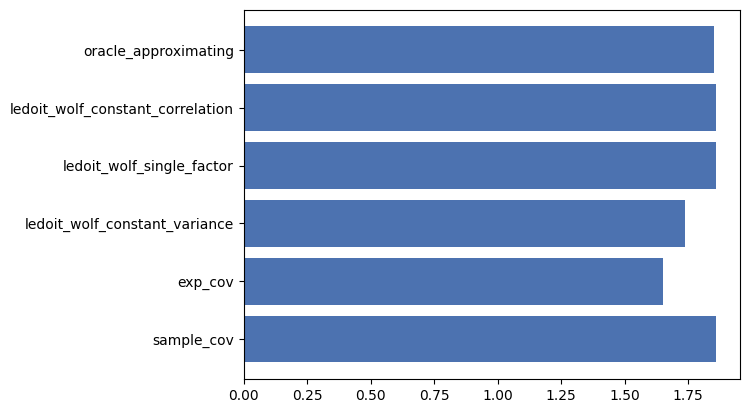

In [198]:
def varError(prices, future_variance):
  var_abs_errors = []
  for method in risk_methods:
      S = risk_models.risk_matrix(prices, method=method)
      variance = np.diag(S)
      var_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
  return var_abs_errors

var_abs_errors = varError(prices, future_variance)
xrange = range(len(var_abs_errors))
plt.barh(xrange, var_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

0.21152561659956026
1.8038038253187938
2.0131953965204232


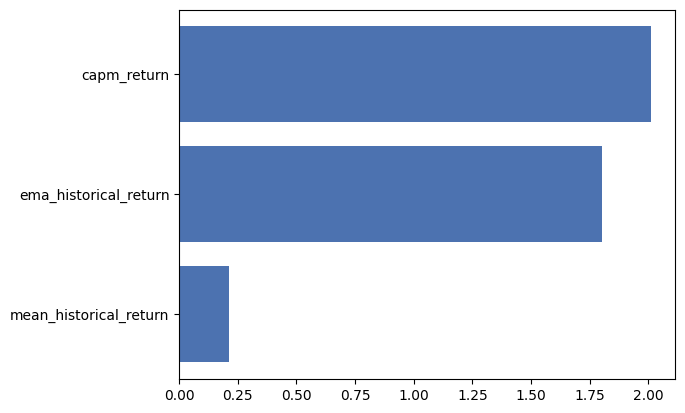

In [199]:
def meanError(past_df, future_rets):
  mean_abs_errors = []
  for method in return_methods:
      mu = expected_returns.return_model(past_df, method=method)
      print(np.sum(np.abs(mu - future_rets)) / len(mu))
      mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
  return mean_abs_errors

mean_abs_errors = meanError(past_df, future_rets)
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

# Optimization

In [200]:
def optimize(ef, objective, value):
  if objective == 'min_volatility':
    ef.min_volatility()
  elif objective == 'max_sharpe':
    ef.max_sharpe()
  elif objective == 'max_quadratic_utility':
    ef.max_quadratic_utility(value)
  elif objective == 'efficient_risk':
    ef.efficient_risk(value)
  elif objective == 'efficient_return':
    ef.efficient_return(value)
  weights = ef.clean_weights()
  return weights

In [201]:
def add_constraint(ef, ticker, sign, value):
  if sign == '=':
    ef.add_constraint(lambda w: w[ef.tickers.index(ticker)] == value)
  elif sign == '<=':
    ef.add_constraint(lambda w: w[ef.tickers.index(ticker)] <= value)
  elif sign == '>=':
    ef.add_constraint(lambda w: w[ef.tickers.index(ticker)] >= value)

## Mean-Variance Optimization

In [202]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
weights = []
# weights = optimizer
for optkey, optvalue in optimizer.items():
  weight = {}
  ef = EfficientFrontier(mu, S)
  ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  ef.add_sector_constraints(country_mapper, country_lower, country_upper)
  for contraintKey, value in weight_contraint.items():
    add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
  weight['weight'] = optimize(ef, optkey, optvalue)
  weight['objective'] = optkey
  weight['portfolio_performance'] = list(ef.portfolio_performance(verbose=False))
  weight['ef'] = ef
  weights.append(weight)

In [203]:
df = pd.DataFrame(weights)
df_weight = pd.DataFrame(list(df['weight']))
df_portfolio_performance = pd.DataFrame(list(df['portfolio_performance']), columns =['Expected annual return', 'Annual volatility','Sharpe Ratio'])
df = pd.concat([df_weight, df_portfolio_performance, df], axis = 1)
df

,ACN,AMZN,BA,COST,DIS,F,GILD,JD,JPM,KO,...,^IRX,^TNX,^TYX,Expected annual return,Annual volatility,Sharpe Ratio,weight,objective,portfolio_performance,ef
0,0.07100,0.05297,0.03546,0.09975,0.06991,0.03724,0.03799,0.03810,0.05747,0.10561,...,0.00131,0.02936,0.07254,0.174658,0.230251,0.671694,"{'ACN': 0.071, 'AMZN': 0.05297, 'BA': 0.03546,...",min_volatility,"[0.17465822917278884, 0.23025110324216144, 0.6...",<pypfopt.efficient_frontier.efficient_frontier...
1,0.05434,0.02666,0.07088,0.03967,0.05375,0.03240,0.03218,0.04000,0.05955,0.03465,...,0.07710,0.06701,0.04685,1.257194,0.651230,1.899782,"{'ACN': 0.05434, 'AMZN': 0.02666, 'BA': 0.0708...",max_sharpe,"[1.2571944956683296, 0.6512296909474421, 1.899...",<pypfopt.efficient_frontier.efficient_frontier...
2,0.00000,0.00000,0.02397,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.44244,0.09616,0.00000,6.373960,3.512816,1.808794,"{'ACN': 0.0, 'AMZN': 0.0, 'BA': 0.02397, 'COST...",max_quadratic_utility,"[6.373959940403546, 3.512815888377874, 1.80879...",<pypfopt.efficient_frontier.efficient_frontier...
3,0.05886,0.03380,0.06127,0.05598,0.05814,0.03372,0.03376,0.03948,0.05898,0.05391,...,0.05653,0.05679,0.05382,0.963377,0.500000,1.886753,"{'ACN': 0.05886, 'AMZN': 0.0338, 'BA': 0.06127...",efficient_risk,"[0.9633766322087102, 0.5000000005915487, 1.886...",<pypfopt.efficient_frontier.efficient_frontier...
4,0.07100,0.05297,0.03546,0.09975,0.06991,0.03724,0.03799,0.03810,0.05747,0.10561,...,0.00131,0.02936,0.07254,0.174658,0.230251,0.671694,"{'ACN': 0.071, 'AMZN': 0.05297, 'BA': 0.03546,...",efficient_return,"[0.17465822917278884, 0.23025110324216144, 0.6...",<pypfopt.efficient_frontier.efficient_frontier...


### L2 Regression

In [204]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
weightsL2 = []
# weights = optimizer
for optkey, optvalue in optimizer.items():
  weight = {}
  ef = EfficientFrontier(mu, S)
  ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  ef.add_sector_constraints(country_mapper, country_lower, country_upper)
  for contraintKey, value in weight_contraint.items():
    add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)
  weight['weight'] = optimize(ef, optkey, optvalue)
  weight['objective'] = optkey
  weight['portfolio_performance'] = list(ef.portfolio_performance(verbose=False))
  weight['ef'] = ef
  weightsL2.append(weight)

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [205]:
df = pd.DataFrame(weights)
df_weight = pd.DataFrame(list(df['weight']))
df_portfolio_performance = pd.DataFrame(list(df['portfolio_performance']), columns =['Expected annual return', 'Annual volatility','Sharpe Ratio'])
df = pd.concat([df_weight, df_portfolio_performance, df], axis = 1)
df

,ACN,AMZN,BA,COST,DIS,F,GILD,JD,JPM,KO,...,^IRX,^TNX,^TYX,Expected annual return,Annual volatility,Sharpe Ratio,weight,objective,portfolio_performance,ef
0,0.07100,0.05297,0.03546,0.09975,0.06991,0.03724,0.03799,0.03810,0.05747,0.10561,...,0.00131,0.02936,0.07254,0.174658,0.230251,0.671694,"{'ACN': 0.071, 'AMZN': 0.05297, 'BA': 0.03546,...",min_volatility,"[0.17465822917278884, 0.23025110324216144, 0.6...",<pypfopt.efficient_frontier.efficient_frontier...
1,0.05434,0.02666,0.07088,0.03967,0.05375,0.03240,0.03218,0.04000,0.05955,0.03465,...,0.07710,0.06701,0.04685,1.257194,0.651230,1.899782,"{'ACN': 0.05434, 'AMZN': 0.02666, 'BA': 0.0708...",max_sharpe,"[1.2571944956683296, 0.6512296909474421, 1.899...",<pypfopt.efficient_frontier.efficient_frontier...
2,0.00000,0.00000,0.02397,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.44244,0.09616,0.00000,6.373960,3.512816,1.808794,"{'ACN': 0.0, 'AMZN': 0.0, 'BA': 0.02397, 'COST...",max_quadratic_utility,"[6.373959940403546, 3.512815888377874, 1.80879...",<pypfopt.efficient_frontier.efficient_frontier...
3,0.05886,0.03380,0.06127,0.05598,0.05814,0.03372,0.03376,0.03948,0.05898,0.05391,...,0.05653,0.05679,0.05382,0.963377,0.500000,1.886753,"{'ACN': 0.05886, 'AMZN': 0.0338, 'BA': 0.06127...",efficient_risk,"[0.9633766322087102, 0.5000000005915487, 1.886...",<pypfopt.efficient_frontier.efficient_frontier...
4,0.07100,0.05297,0.03546,0.09975,0.06991,0.03724,0.03799,0.03810,0.05747,0.10561,...,0.00131,0.02936,0.07254,0.174658,0.230251,0.671694,"{'ACN': 0.071, 'AMZN': 0.05297, 'BA': 0.03546,...",efficient_return,"[0.17465822917278884, 0.23025110324216144, 0.6...",<pypfopt.efficient_frontier.efficient_frontier...


In [206]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
L2weights = []
# weights = optimizer
for optkey, optvalue in optimizer.items():
  L2weight = {}
  ef = EfficientFrontier(mu, S)
  ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  ef.add_sector_constraints(country_mapper, country_lower, country_upper)
  for contraintKey, value in weight_contraint.items():
    add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)
  L2weight['weight'] = optimize(ef, optkey, optvalue)
  L2weight['objective'] = optkey
  L2weight['portfolio_performance'] = list(ef.portfolio_performance(verbose=False))
  L2weight['ef'] = ef
  L2weights.append(L2weight)

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


## Hierarchical Risk Parity

In [207]:
rets = expected_returns.returns_from_prices(prices)
hrp = HRPOpt(rets)
hrp.optimize()
hrpweights = hrp.clean_weights()
hrpweights

OrderedDict([('ACN', 0.03025),
             ('AMZN', 0.03609),
             ('BA', 0.01519),
             ('COST', 0.09577),
             ('DIS', 0.03319),
             ('F', 0.0364),
             ('GILD', 0.08711),
             ('JD', 0.04136),
             ('JPM', 0.0514),
             ('KO', 0.15323),
             ('MA', 0.03965),
             ('MSFT', 0.02414),
             ('PFE', 0.12266),
             ('TSLA', 0.02801),
             ('UNH', 0.0767),
             ('XOM', 0.04601),
             ('^FVX', 0.01051),
             ('^IRX', 0.00014),
             ('^TNX', 0.01628),
             ('^TYX', 0.05591)])

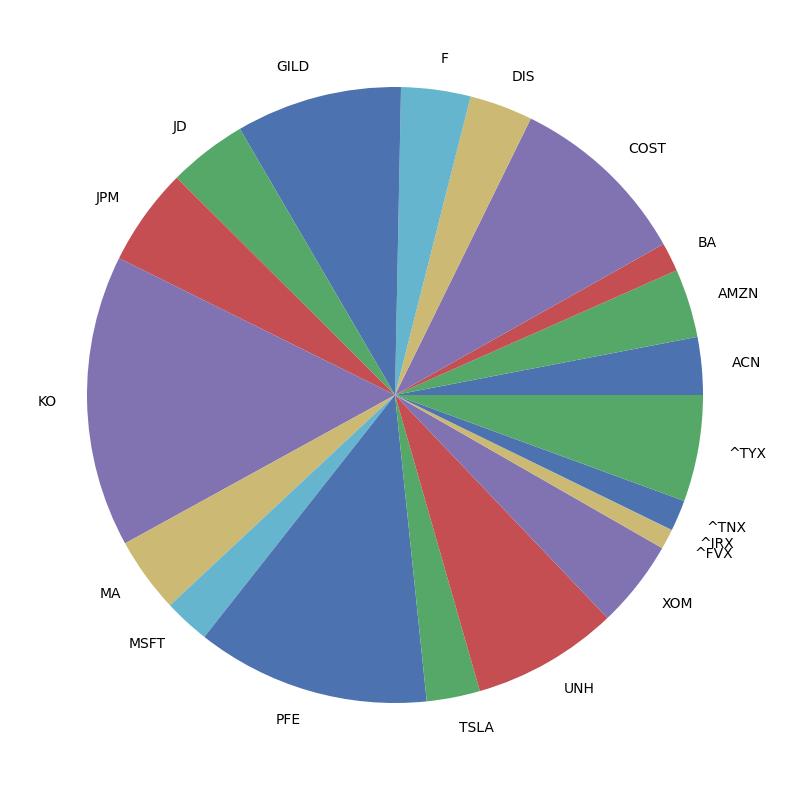

In [208]:
pd.Series(hrpweights).plot.pie(figsize=(10, 10));

In [209]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 15.4%
Annual volatility: 16.9%
Sharpe Ratio: 0.79


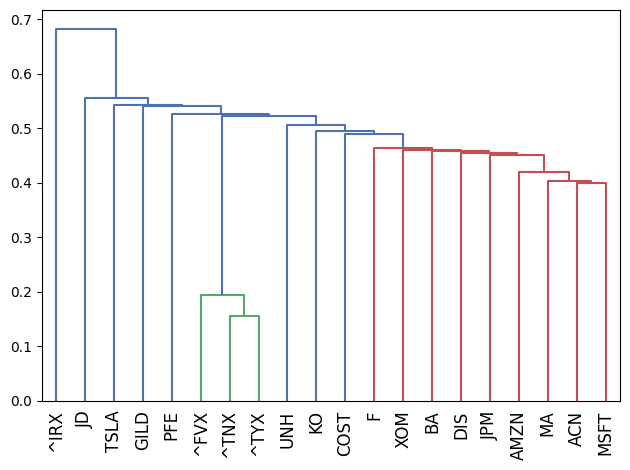

In [210]:
plotting.plot_dendrogram(hrp);

In [211]:
mu = expected_returns.mean_historical_return(prices)
historical_returns = expected_returns.returns_from_prices(prices)

es = EfficientSemivariance(mu, historical_returns)
es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
es.add_sector_constraints(country_mapper, country_lower, country_upper)
es.efficient_return(0.20)
# We can use the same helper methods as before
EfficientSemivarianceweights = es.clean_weights()
print(EfficientSemivarianceweights)
es.portfolio_performance(verbose=True)

OrderedDict([('ACN', 0.0), ('AMZN', 0.0846), ('BA', 0.0), ('COST', 0.3772), ('DIS', 0.0), ('F', 0.0), ('GILD', 0.0), ('JD', 0.0), ('JPM', 0.0), ('KO', 0.19598), ('MA', 0.0), ('MSFT', 0.2), ('PFE', 0.0), ('TSLA', 0.0154), ('UNH', 0.1), ('XOM', 0.0), ('^FVX', 0.0), ('^IRX', 0.00265), ('^TNX', 0.0), ('^TYX', 0.02418)])
Expected annual return: 20.0%
Annual semi-deviation: 12.5%
Sortino Ratio: 1.44


(0.20000084974496654, 0.12480432453419049, 1.4422645242205114)

In [212]:
mu = expected_returns.mean_historical_return(prices)
historical_returns = expected_returns.returns_from_prices(prices)

es = EfficientCVaR(mu, historical_returns)
es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
es.add_sector_constraints(country_mapper, country_lower, country_upper)
es.efficient_return(0.20)
# We can use the same helper methods as before
EfficientCVaRweights = es.clean_weights()
print(EfficientCVaRweights)
es.portfolio_performance(verbose=True)

OrderedDict([('ACN', 0.0), ('AMZN', 0.1), ('BA', 0.0), ('COST', 0.39357), ('DIS', 0.0), ('F', 0.0), ('GILD', 0.0), ('JD', 0.0), ('JPM', 0.0), ('KO', 0.21396), ('MA', 0.0), ('MSFT', 0.19098), ('PFE', 0.0), ('TSLA', 0.0), ('UNH', 0.1), ('XOM', 0.0), ('^FVX', 0.0), ('^IRX', 0.00149), ('^TNX', 0.0), ('^TYX', 0.0)])
Expected annual return: 20.0%
Conditional Value at Risk: 2.68%


(0.1999999999999941, 0.026796756851060154)

## Mean-Semivariance Optimization

In [213]:
mu = expected_returns.mean_historical_return(prices)
historical_returns = expected_returns.returns_from_prices(prices)
es = EfficientSemivariance(mu, historical_returns)
weightsEfficientSemivariance = []
for optkey, optvalue in optimizer.items():
  weight = {}
  es = EfficientFrontier(mu, S)
  es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  es.add_sector_constraints(country_mapper, country_lower, country_upper)
  for contraintKey, value in weight_contraint.items():
    add_constraint(es, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
    es.add_objective(objective_functions.L2_reg, gamma=0.1)
  weight['weight'] = optimize(es, optkey, optvalue)
  weight['objective'] = optkey
  weight['portfolio_performance'] = list(es.portfolio_performance(verbose=False))
  weight['ef'] = ef
  weightsEfficientSemivariance.append(weight)

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


## Conditional CVaR Optimization

In [214]:
mu = expected_returns.mean_historical_return(prices)
historical_returns = expected_returns.returns_from_prices(prices)
es = EfficientCVaR(mu, historical_returns)
weightsEfficientCVaR = []
for optkey, optvalue in optimizer.items():
  weight = {}
  es = EfficientFrontier(mu, S)
  es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  es.add_sector_constraints(country_mapper, country_lower, country_upper)
  for contraintKey, value in weight_contraint.items():
    add_constraint(es, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
    es.add_objective(objective_functions.L2_reg, gamma=0.1)
  weight['weight'] = optimize(es, optkey, optvalue)
  weight['objective'] = optkey
  weight['portfolio_performance'] = list(es.portfolio_performance(verbose=False))
  weight['ef'] = ef
  weightsEfficientCVaR.append(weight)

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


## Conditional CDaR Optimization

In [215]:
mu = expected_returns.mean_historical_return(prices)
historical_returns = expected_returns.returns_from_prices(prices)
es = EfficientCDaR(mu, historical_returns)
weightsEfficientCDaR = []
for optkey, optvalue in optimizer.items():
  weight = {}
  es = EfficientFrontier(mu, S)
  es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  es.add_sector_constraints(country_mapper, country_lower, country_upper)
  for contraintKey, value in weight_contraint.items():
    add_constraint(es, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
    es.add_objective(objective_functions.L2_reg, gamma=0.1)
  weight['weight'] = optimize(es, optkey, optvalue)
  weight['objective'] = optkey
  weight['portfolio_performance'] = list(es.portfolio_performance(verbose=False))
  weight['ef'] = ef
  weightsEfficientCDaR.append(weight)

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


## Black-Litterman Optimization

# Evaluation

In [216]:
def sectorDistribution(weights):
  for sector in set(sector_mapper.values()):
      total_weight = 0
      for t,w in weights.items():
          if sector_mapper[t] == sector:
              total_weight += w
      print(f"{sector}: {total_weight:.3f}")

def counntryDistribution(weights):   
  for country in set(country_mapper.values()):
      total_weight = 0
      for t,w in weights.items():
          if country_mapper[t] == country:
              total_weight += w
      print(f"{country}: {total_weight:.3f}")

def zeroWeight(weights):
  num_small = len([k for k in weights if weights[k] <= 1e-4])
  print(f"{num_small}/{len(tickers)} tickers have zero weight")

def allocation(weights):
  latest_prices = prices.iloc[-2]  # prices as of the day you are allocating
  da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
  alloc, leftover = da.lp_portfolio()
  print(f"Discrete allocation performed with ${leftover:.2f} leftover")
  print(alloc)

## Mean-Variance Optimization

In [217]:
print("---------------------Mean-Variance Optimization---------------------")
for item in weights:
  print("---------------------"+item['objective']+"---------------------")
  print("-----------------Sector Distribution-----------------")
  sectorDistribution(item['weight'])
  print("-----------------Country Distribution-----------------")
  counntryDistribution(item['weight'])
  zeroWeight(item['weight'])
  # allocation(item['weight'])
  # pd.Series(item['weight']).plot.pie(figsize=(10, 10))

---------------------Mean-Variance Optimization---------------------
---------------------min_volatility---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.205
Financial Services: 0.115
Energy: 0.075
Healthcare: 0.100
Communication Services: 0.070
Industrials: 0.035
None: 0.114
Technology: 0.136
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.777
None: 0.114
China: 0.038
Ireland: 0.071
0/20 tickers have zero weight
---------------------max_sharpe---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.074
Financial Services: 0.121
Energy: 0.050
Healthcare: 0.100
Communication Services: 0.054
Industrials: 0.071
None: 0.266
Technology: 0.114
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.639
None: 0.266
China: 0.040
Ireland: 0.054
0/20 tickers have zero weight
---------------------max_quadratic_utility---

## Mean-Variance Optimization with L2 Regression

In [218]:
print("---------------------Mean-Variance Optimization with L2 Regression---------------------")
for item in weightsL2:
  print("---------------------"+item['objective']+"---------------------")
  print("-----------------Sector Distribution-----------------")
  sectorDistribution(item['weight'])
  print("-----------------Country Distribution-----------------")
  counntryDistribution(item['weight'])
  zeroWeight(item['weight'])
  # allocation(item['weight'])
  # pd.Series(item['weight']).plot.pie(figsize=(10, 10))

---------------------Mean-Variance Optimization with L2 Regression---------------------
---------------------min_volatility---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.182
Financial Services: 0.120
Energy: 0.072
Healthcare: 0.100
Communication Services: 0.069
Industrials: 0.045
None: 0.127
Technology: 0.136
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.765
None: 0.127
China: 0.038
Ireland: 0.070
0/20 tickers have zero weight
---------------------max_sharpe---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.069
Financial Services: 0.117
Energy: 0.048
Healthcare: 0.100
Communication Services: 0.052
Industrials: 0.070
None: 0.287
Technology: 0.108
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.622
None: 0.287
China: 0.039
Ireland: 0.052
0/20 tickers have zero weight
---------------------max_q

## Conditional CVaR Optimization

In [219]:
print("---------------------Conditional CVaR Optimization---------------------")
for item in weightsEfficientCVaR:
  print("---------------------"+item['objective']+"---------------------")
  print("-----------------Sector Distribution-----------------")
  sectorDistribution(item['weight'])
  print("-----------------Country Distribution-----------------")
  counntryDistribution(item['weight'])
  zeroWeight(item['weight'])
  # allocation(item['weight'])
  # pd.Series(item['weight']).plot.pie(figsize=(10, 10))

---------------------Conditional CVaR Optimization---------------------
---------------------min_volatility---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.182
Financial Services: 0.120
Energy: 0.072
Healthcare: 0.100
Communication Services: 0.069
Industrials: 0.045
None: 0.127
Technology: 0.136
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.765
None: 0.127
China: 0.038
Ireland: 0.070
0/20 tickers have zero weight
---------------------max_sharpe---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.238
Financial Services: 0.237
Energy: 0.025
Healthcare: 0.100
Communication Services: 0.000
Industrials: 0.008
None: 0.042
Technology: 0.200
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.904
None: 0.042
China: 0.000
Ireland: 0.054
7/20 tickers have zero weight
---------------------max_quadratic_utility

## Conditional CDaR Optimization

In [220]:
print("---------------------Conditional CDaR Optimization---------------------")
for item in weightsEfficientCDaR:
  print("---------------------"+item['objective']+"---------------------")
  print("-----------------Sector Distribution-----------------")
  sectorDistribution(item['weight'])
  print("-----------------Country Distribution-----------------")
  counntryDistribution(item['weight'])
  zeroWeight(item['weight'])
  # allocation(item['weight'])
  # pd.Series(item['weight']).plot.pie(figsize=(10, 10))

---------------------Conditional CDaR Optimization---------------------
---------------------min_volatility---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.182
Financial Services: 0.120
Energy: 0.072
Healthcare: 0.100
Communication Services: 0.069
Industrials: 0.045
None: 0.127
Technology: 0.136
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.765
None: 0.127
China: 0.038
Ireland: 0.070
0/20 tickers have zero weight
---------------------max_sharpe---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.238
Financial Services: 0.237
Energy: 0.025
Healthcare: 0.100
Communication Services: 0.000
Industrials: 0.008
None: 0.042
Technology: 0.200
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.904
None: 0.042
China: 0.000
Ireland: 0.054
7/20 tickers have zero weight
---------------------max_quadratic_utility

## Mean-Semivariance Optimization

In [221]:
print("---------------------Mean-Semivariance Optimization---------------------")
for item in weightsEfficientSemivariance:
  print("---------------------"+item['objective']+"---------------------")
  print("-----------------Sector Distribution-----------------")
  sectorDistribution(item['weight'])
  print("-----------------Country Distribution-----------------")
  counntryDistribution(item['weight'])
  zeroWeight(item['weight'])
  # allocation(item['weight'])
  # pd.Series(item['weight']).plot.pie(figsize=(10, 10))

---------------------Mean-Semivariance Optimization---------------------
---------------------min_volatility---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.182
Financial Services: 0.120
Energy: 0.072
Healthcare: 0.100
Communication Services: 0.069
Industrials: 0.045
None: 0.127
Technology: 0.136
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.765
None: 0.127
China: 0.038
Ireland: 0.070
0/20 tickers have zero weight
---------------------max_sharpe---------------------
-----------------Sector Distribution-----------------
Consumer Defensive: 0.238
Financial Services: 0.237
Energy: 0.025
Healthcare: 0.100
Communication Services: 0.000
Industrials: 0.008
None: 0.042
Technology: 0.200
Consumer Cyclical: 0.150
-----------------Country Distribution-----------------
United States: 0.904
None: 0.042
China: 0.000
Ireland: 0.054
7/20 tickers have zero weight
---------------------max_quadratic_utilit

# Portfolio Comparison with various optimizer

In [222]:
portfolio = pd.DataFrame()
startDate = datetime(2020,1,1)
price = prices.loc[(prices.index >= startDate- relativedelta(days=180)) & (prices.index < startDate)]
postPrice = prices.loc[(prices.index >= startDate) & (prices.index < startDate + relativedelta(months=1))]
price

,ACN,AMZN,BA,COST,DIS,F,GILD,JD,JPM,KO,MA,MSFT,PFE,TSLA,UNH,XOM,^FVX,^IRX,^TNX,^TYX
Date,,,,,,,,,,,,,,,,,,,,
2019-07-05,181.320099,97.145500,349.521729,253.970276,141.601624,8.703969,58.726910,29.817873,101.191101,46.392853,266.290741,132.024017,36.282295,15.540000,233.746994,61.869045,1.842,2.163,2.048,2.549
2019-07-08,180.296921,97.615997,344.866150,255.059036,140.180145,8.703969,57.827114,29.375841,100.638290,46.294918,265.722565,131.927719,35.770115,15.356000,234.551437,62.153503,1.844,2.178,2.034,2.520
2019-07-09,181.035919,99.415001,346.801117,255.598724,140.766632,8.652770,58.058491,29.548809,101.066261,45.929893,267.789703,131.446075,35.827946,15.337333,232.810059,62.112850,1.867,2.195,2.054,2.531
2019-07-10,181.623276,100.870499,346.025146,256.971497,142.685135,8.627169,57.809971,29.510372,100.772034,46.134659,269.788300,132.785004,36.397949,15.928000,234.210709,62.990543,1.828,2.130,2.061,2.571
2019-07-11,184.427521,100.053497,352.605835,261.818878,142.705017,8.695436,56.721645,29.318186,101.734985,46.330524,272.668549,133.314804,35.505772,15.906667,247.157257,63.039299,1.877,2.098,2.120,2.641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,201.337570,89.460503,331.030457,279.790009,145.289993,8.336252,58.251301,34.862793,123.653152,49.430199,291.793365,152.619797,33.077724,28.350000,281.138672,58.305904,1.724,1.538,1.910,2.339
2019-12-26,201.756210,93.438499,327.968689,281.216400,145.699997,8.318645,57.963177,34.824356,124.965363,49.710281,293.480499,153.870804,33.153496,28.729334,282.198212,58.397507,1.725,1.535,1.905,2.337
2019-12-27,201.917953,93.489998,328.187408,279.675873,145.750000,8.239420,57.579029,34.526463,125.055229,50.008434,294.990967,154.152039,33.102985,28.691999,282.503632,58.197655,1.678,1.518,1.874,2.311


In [223]:
mu = expected_returns.mean_historical_return(price)
S = risk_models.exp_cov(price)
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_sector_constraints(country_mapper, country_lower, country_upper)
# ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
for contraintKey, value in weight_contraint.items():
    add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
ef.efficient_return(0.20)
EfficientFrontierweights = ef.clean_weights()
weighted_prices = postPrice * EfficientFrontierweights.values()
portfolio['Mean-Variance'] = weighted_prices.sum(axis=1)
EfficientFrontierweights = np.array(list(EfficientFrontierweights.values()))

In [224]:
mu = expected_returns.mean_historical_return(price)
historical_returns = expected_returns.returns_from_prices(price)
es = EfficientCVaR(mu, historical_returns)
es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
es.add_sector_constraints(country_mapper, country_lower, country_upper)
# es.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
for contraintKey, value in weight_contraint.items():
    add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
es.efficient_return(0.20)
# We can use the same helper methods as before
EfficientCVaRweights = es.clean_weights()
weighted_prices = postPrice * EfficientCVaRweights.values()
portfolio['EfficientCVaR'] = weighted_prices.sum(axis=1)
EfficientCVaRweights = np.array(list(EfficientCVaRweights.values()))

In [225]:
mu = expected_returns.mean_historical_return(price)
historical_returns = expected_returns.returns_from_prices(price)
es = EfficientSemivariance(mu, historical_returns)
es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
es.add_sector_constraints(country_mapper, country_lower, country_upper)
# es.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
for contraintKey, value in weight_contraint.items():
    add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
es.efficient_return(0.20)
EfficientSemivarianceweights = es.clean_weights()
weighted_prices = postPrice * EfficientSemivarianceweights.values()
portfolio['EfficientSemivariance'] = weighted_prices.sum(axis=1)
EfficientSemivarianceweights = np.array(list(EfficientSemivarianceweights.values()))

In [226]:
mu = expected_returns.mean_historical_return(price)
historical_returns = expected_returns.returns_from_prices(price)
es = EfficientCDaR(mu, historical_returns)
es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
es.add_sector_constraints(country_mapper, country_lower, country_upper)
# es.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
for contraintKey, value in weight_contraint.items():
    add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
es.efficient_return(0.20)
EfficientCDaRweights = es.clean_weights()
weighted_prices = postPrice * EfficientCDaRweights.values()
portfolio['EfficientCDaR'] = weighted_prices.sum(axis=1)
EfficientCDaRweights = np.array(list(EfficientCDaRweights.values()))

In [227]:
portfolio

,Mean-Variance,EfficientCVaR,EfficientSemivariance,EfficientCDaR
Date,,,,
2020-01-02,124.788088,172.139567,131.378597,78.606494
2020-01-03,124.425947,171.859548,130.971017,77.894210
2020-01-06,124.571440,172.029323,131.151471,77.889478
2020-01-07,124.204173,171.378638,130.519693,77.444032
2020-01-08,125.030305,173.358891,132.010235,78.014901
2020-01-09,126.414385,175.445976,133.399694,78.835892
2020-01-10,125.766151,174.767286,133.051623,78.758591
2020-01-13,126.231422,175.280065,133.205451,79.501036
2020-01-14,126.491949,175.356621,133.324138,79.395171


In [228]:
def EfficientFrontierOpt(price, EfficientFrontierweights):
  mu = expected_returns.mean_historical_return(price)
  S = risk_models.exp_cov(price)
  ef = EfficientFrontier(mu, S)
  ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  ef.add_sector_constraints(country_mapper, country_lower, country_upper)
  ef.add_objective(objective_functions.transaction_cost, w_prev=EfficientFrontierweights, k=0.01)
  for contraintKey, value in weight_contraint.items():
      add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
  ef.efficient_return(0.20)
  EfficientFrontierweights = ef.clean_weights()
  EfficientFrontierweights = np.array(list(EfficientFrontierweights.values()))
  return EfficientFrontierweights

def EfficientCVaROpt(price, EfficientCVaRweights):
  mu = expected_returns.mean_historical_return(price)
  historical_returns = expected_returns.returns_from_prices(price)
  es = EfficientCVaR(mu, historical_returns)
  es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  es.add_sector_constraints(country_mapper, country_lower, country_upper)
  es.add_objective(objective_functions.transaction_cost, w_prev=EfficientCVaRweights, k=0.01)
  for contraintKey, value in weight_contraint.items():
      add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
  es.efficient_return(0.20)
  EfficientCVaRweights = es.clean_weights()
  EfficientCVaRweights = np.array(list(EfficientCVaRweights.values()))
  return EfficientCVaRweights

def EfficientSemivarianceOpt(price, EfficientSemivarianceweights):
  mu = expected_returns.mean_historical_return(price)
  historical_returns = expected_returns.returns_from_prices(price)
  es = EfficientSemivariance(mu, historical_returns)
  es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  es.add_sector_constraints(country_mapper, country_lower, country_upper)
  es.add_objective(objective_functions.transaction_cost, w_prev=EfficientSemivarianceweights, k=0.01)
  for contraintKey, value in weight_contraint.items():
      add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
  es.efficient_return(0.20)
  EfficientSemivarianceweights = es.clean_weights()
  EfficientSemivarianceweights = np.array(list(EfficientSemivarianceweights.values()))
  return EfficientSemivarianceweights

def EfficientCDaROpt(price, EfficientCDaRweights):
  mu = expected_returns.mean_historical_return(price)
  historical_returns = expected_returns.returns_from_prices(price)
  es = EfficientCDaR(mu, historical_returns)
  es.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
  es.add_sector_constraints(country_mapper, country_lower, country_upper)
  es.add_objective(objective_functions.transaction_cost, w_prev=EfficientCDaRweights, k=0.01)
  for contraintKey, value in weight_contraint.items():
      add_constraint(ef, contraintKey, weight_contraint[contraintKey]['value'], weight_contraint[contraintKey]['sign'])
  es.efficient_return(0.20)
  EfficientCDaRweights = es.clean_weights()
  EfficientCDaRweights = np.array(list(EfficientCDaRweights.values()))
  return EfficientCDaRweights

In [229]:
for i in range(1,21):
  DF = pd.DataFrame()
  startDate = startDate + relativedelta(months=1)
  price = prices.loc[(prices.index >= startDate- relativedelta(days=180)) & (prices.index < startDate)]
  postPrice = prices.loc[(prices.index >= startDate) & (prices.index < startDate + relativedelta(months=1))]
  EfficientFrontierweights = EfficientFrontierOpt(price, EfficientFrontierweights)
  EfficientFrontierPrices = postPrice * EfficientFrontierweights
  DF['Mean-Variance'] = EfficientFrontierPrices.sum(axis=1)
  EfficientCVaRweights = EfficientCVaROpt(price, EfficientCVaRweights)
  EfficientCVaRPrices = postPrice * EfficientCVaRweights
  DF['EfficientCVaR'] = EfficientCVaRPrices.sum(axis=1)
  EfficientSemivarianceweights = EfficientSemivarianceOpt(price, EfficientSemivarianceweights)
  EfficientSemivariancePrices = postPrice * EfficientSemivarianceweights
  DF['EfficientSemivariance'] = EfficientSemivariancePrices.sum(axis=1)
  EfficientCDaRweights = EfficientCDaROpt(price, EfficientCDaRweights)
  EfficientCDaRPrices = postPrice * EfficientCDaRweights
  DF['EfficientCDaR'] = EfficientCDaRPrices.sum(axis=1)
  portfolio = pd.concat([portfolio, DF])

In [230]:
def download(tickers):
  ohlc = yf.download(tickers, period="max")
  prices = ohlc["Adj Close"].dropna(how="all")
  return prices
benchmark = download(['SPY','^IXIC']).dropna()
portfolio = pd.merge(portfolio, benchmark, right_index = True, left_index = True)
portfolio

[*********************100%***********************]  2 of 2 completed


,Mean-Variance,EfficientCVaR,EfficientSemivariance,EfficientCDaR,SPY,^IXIC
Date,,,,,,
2020-01-02,124.788088,172.139567,131.378597,78.606494,308.517395,9092.190430
2020-01-03,124.425947,171.859548,130.971017,77.894210,306.181274,9020.769531
2020-01-06,124.571440,172.029323,131.151471,77.889478,307.349304,9071.469727
2020-01-07,124.204173,171.378638,130.519693,77.444032,306.485199,9068.580078
2020-01-08,125.030305,173.358891,132.010235,78.014901,308.118591,9129.240234
...,...,...,...,...,...,...
2021-09-24,237.724177,310.625508,232.274262,209.491380,433.639008,15047.700195
2021-09-27,234.585525,306.373472,230.544779,206.413335,432.398376,14969.969727
2021-09-28,228.207304,297.894369,224.952969,200.400346,423.684814,14546.679688


In [231]:
returns = portfolio.apply(lambda x: x/x[0])

In [232]:
comprison = pd.DataFrame()
rf = 0.02
comprison['Mean'] = returns.mean()
comprison['Std'] = returns.std()
comprison['Sharpe Ratio'] = (returns.mean() - rf) / returns.std()
comprison

,Mean,Std,Sharpe Ratio
Mean-Variance,1.548144,0.271004,5.638830
EfficientCVaR,1.466654,0.221935,6.518369
EfficientSemivariance,1.327496,0.240999,5.425306
EfficientCDaR,2.544249,0.663939,3.801927
SPY,1.129312,0.179099,6.193844
^IXIC,1.301266,0.246683,5.193971


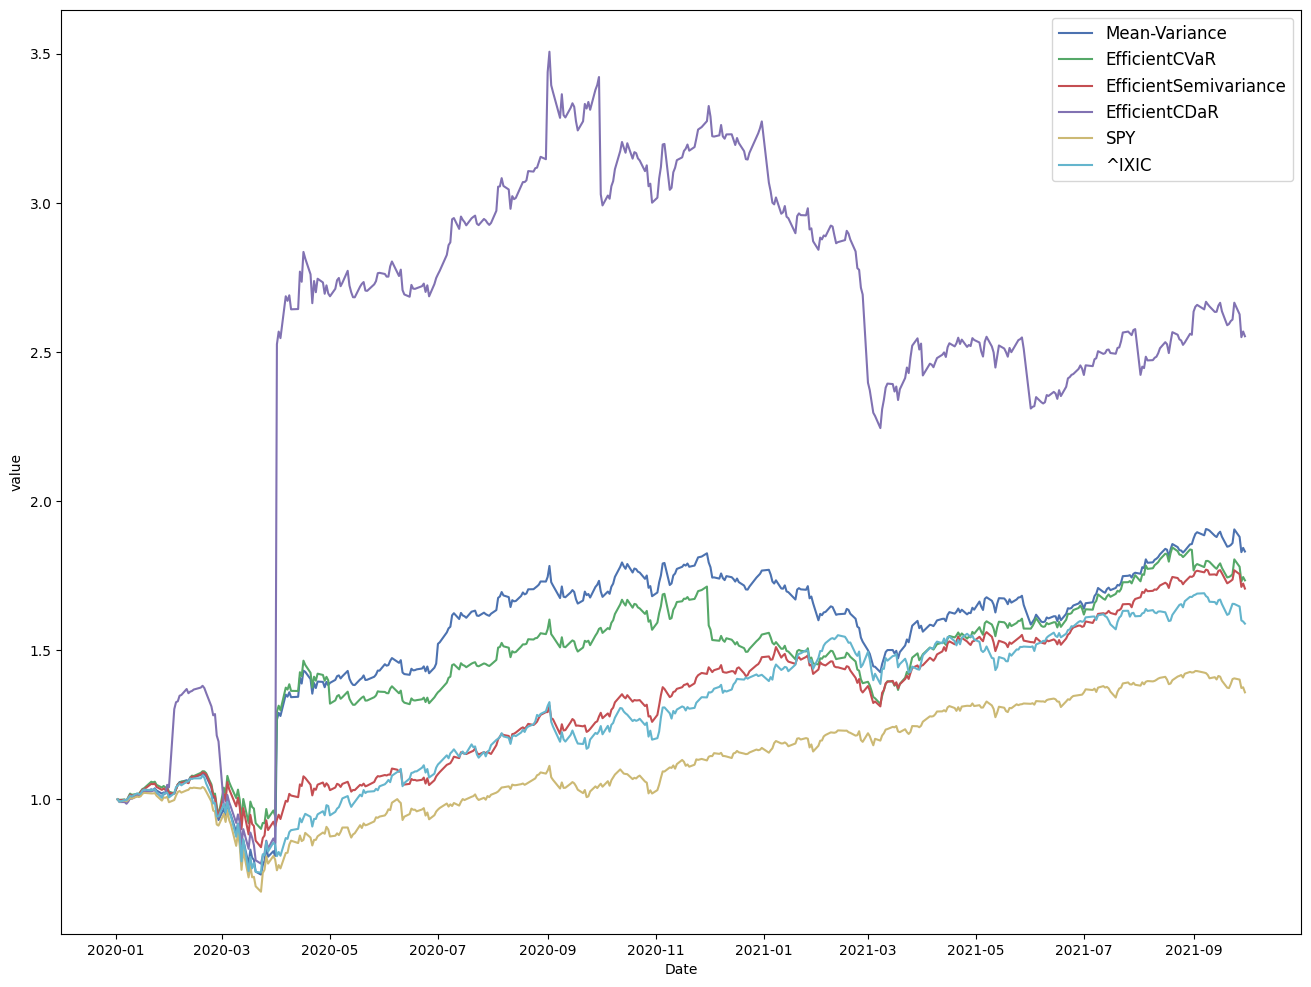

In [233]:
plt.figure(figsize=(16, 12))
melted_df = pd.melt(returns.reset_index(), id_vars=['Date'], var_name='Tickers', value_name='value')
sns.lineplot(x='Date', y='value', hue='Tickers', data=melted_df)
plt.legend(fontsize=12)
plt.show()